In [ ]:
%pip install -r requirements.txt

In [56]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

import numpy as np
import matplotlib.pyplot as plt

from rbm import RBM
from data import exemplars, generate_samples
from train_and_evaluate import mean_squared_error

### Load test data for evaluation

In [141]:
test_data = generate_samples(exemplars, num_samples=240, noise_factor=0.2)

## Evaluate performance of RBM as number of Epochs increase
**Fixed Hyperparamters:**
* Learning Rate: 0.01
* Number of Hidden Units: 100
* Reconstruction Steps: 10

In [125]:
# Train and evaluate model on varying epoch sizes 
epochs_opts = [50, 100, 150]
num_hidden = 120    # Keep number of hidden nodes constant

errors = []
for epochs in epochs_opts:
    # Init model
    model = RBM(100, num_hidden)

    # Train model
    model.train(exemplars, learning_rate=0.01, epochs=epochs, gibbs_steps=1)

    # Evaluate model against noisy test data
    num_avg_errors = [] # average error for each number
    for num, samples in test_data.items():
        results = model.reconstruct(samples)
        
        num_errors = np.array([mean_squared_error(results[i], exemplars[num]) for i in range(len(results))])
        num_avg_errors += [np.mean(num_errors)]
    
    errors += [np.mean(num_avg_errors)]

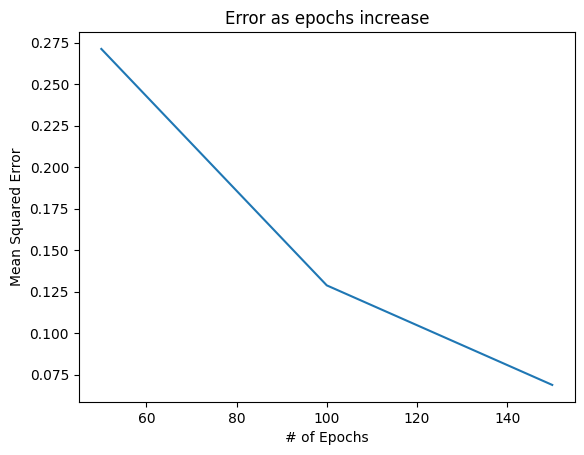

In [126]:
plt.title('Error as epochs increase')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.plot(epochs_opts, errors);

## Evaluate performance of RBM as number of hidden nodes increases
**Fixed Hyperparamters:**
* Epochs: 100
* Learning Rate: 0.01

In [129]:
# Train and evaluate model on varying hidden_node sizes
num_hidden_opts = [80, 100, 120]
epochs = 150    # Keep number of epochs constant

errors = []
for num_hidden in num_hidden_opts:
    # Init model
    model = RBM(100, num_hidden)

    # Train model
    model.train(exemplars, learning_rate=0.01, epochs=epochs, gibbs_steps=1)

    # Evaluate model against noisy test data
    num_avg_errors = [] # average error for each number
    for num, samples in test_data.items():
        results = model.reconstruct(samples)
        
        num_errors = np.array([mean_squared_error(results[i], exemplars[num]) for i in range(len(results))])
        num_avg_errors += [np.mean(num_errors)]
    
    errors += [np.mean(num_avg_errors)]

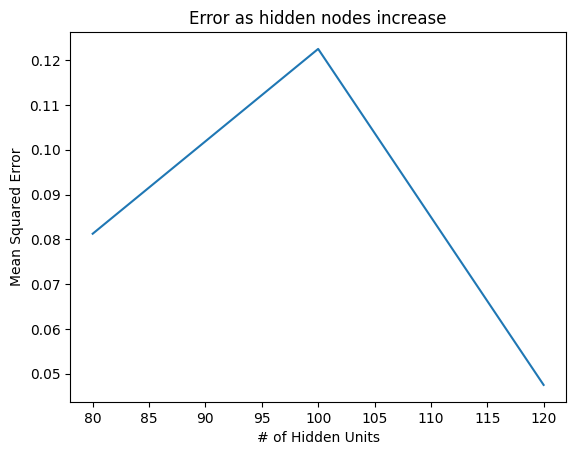

In [130]:
plt.title('Error as hidden nodes increase')
plt.xlabel('# of Hidden Units')
plt.ylabel('Mean Squared Error')
plt.plot(num_hidden_opts, errors);

## Evaluate performance of RBM as gibbs sample size increases
**Fixed Hyperparamters:**
* Epochs: 100
* Learning Rate: 0.01
* Number of Hidden Units: 100

In [134]:
gibbs_steps_opts = [1, 2, 3]
num_hidden = 120    # Keep number of hidden nodes constant
epochs = 150    # Keep number of epochs constant

errors = []
for gibbs_steps in gibbs_steps_opts:
    # Init model
    model = RBM(100, num_hidden)

    # Train model
    model.train(exemplars, epochs=epochs, learning_rate=0.005, gibbs_steps=gibbs_steps)

    # Evaluate model against noisy test data
    num_avg_errors = [] # average error for each number
    for num, samples in test_data.items():
        results = model.reconstruct(samples)
        
        num_errors = np.array([mean_squared_error(results[i], exemplars[num]) for i in range(len(results))])
        num_avg_errors += [np.mean(num_errors)]
    
    errors += [np.mean(num_avg_errors)]

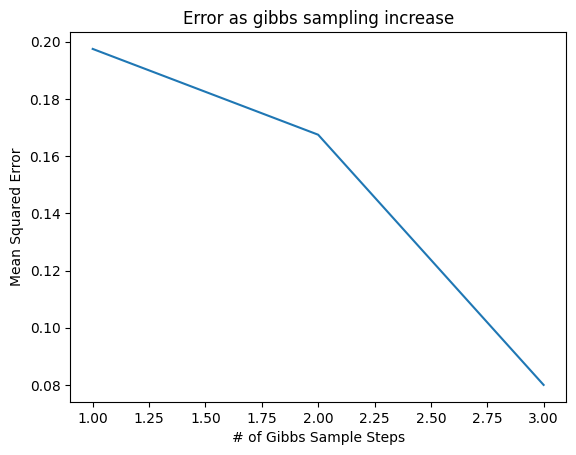

In [135]:
plt.title('Error as gibbs sampling increase')
plt.xlabel('# of Gibbs Sample Steps')
plt.ylabel('Mean Squared Error')
plt.plot(gibbs_steps_opts, errors);

## Evaluate performance of RBM as reconstruction step size increases
**Fixed Hyperparamters:**
* Epochs: 300
* Learning Rate: 0.01
* Number of Hidden Units: 100
* Number of Gibbs Steps: 1

In [139]:
reconstruction_steps_opts = [1, 2]
num_hidden = 120    # Keep number of hidden nodes constant
epochs = 150    # Keep number of epochs constant

errors = []
for reconstruction_steps in reconstruction_steps_opts:
    # Init model
    model = RBM(100, num_hidden)

    # Train model
    model.train(exemplars, epochs=epochs, learning_rate=0.01, gibbs_steps=1)

    # Evaluate model against noisy test data
    num_avg_errors = [] # average error for each number
    for num, samples in test_data.items():
        results = model.reconstruct(samples, iters=reconstruction_steps)
        
        num_errors = np.array([mean_squared_error(results[i], exemplars[num]) for i in range(len(results))])
        num_avg_errors += [np.mean(num_errors)]
    
    errors += [np.mean(num_avg_errors)]

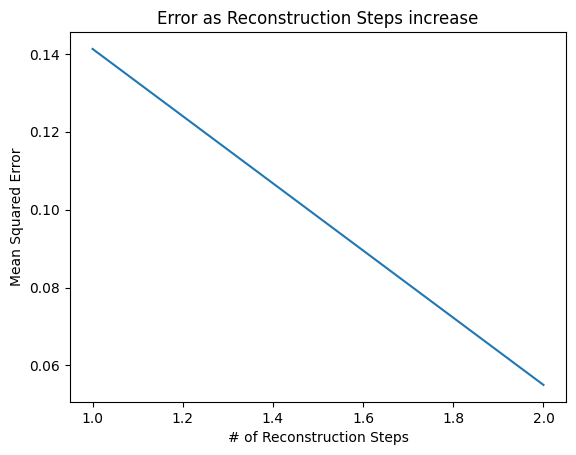

In [140]:
plt.title('Error as Reconstruction Steps increase')
plt.xlabel('# of Reconstruction Steps')
plt.ylabel('Mean Squared Error')
plt.plot(reconstruction_steps_opts, errors);

## Evaluate performance of RBM as noise level increases
**Fixed Hyperparamters:**
* Epochs: 100
* Learning Rate: 0.01
* Number of Hidden Units: 100
* Number of Gibbs Steps: 1
* Number of Reconstruction Steps: 1

In [142]:
noise_factor_opts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_hidden = 120    # Keep number of hidden nodes constant
epochs = 150    # Keep number of epochs constant

errors = []
for noise_factor in noise_factor_opts:
    test_data_tmp =  generate_samples(exemplars, 50, noise_factor=noise_factor)

    # Init model
    model = RBM(100, num_hidden)

    # Train model
    model.train(exemplars, epochs=epochs, learning_rate=0.01, gibbs_steps=1)

    # Evaluate model against noisy test data
    num_avg_errors = [] # average error for each number
    for num, samples in test_data_tmp.items():
        results = model.reconstruct(samples, iters=reconstruction_steps)
        
        num_errors = np.array([mean_squared_error(results[i], exemplars[num]) for i in range(len(results))])
        num_avg_errors += [np.mean(num_errors)]
    
    errors += [np.mean(num_avg_errors)]

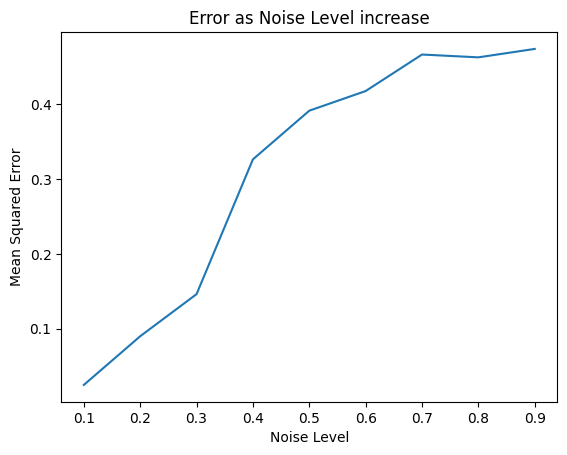

In [143]:
plt.title('Error as Noise Level increase')
plt.xlabel('Noise Level')
plt.ylabel('Mean Squared Error')
plt.plot(noise_factor_opts, errors);